# Superbowl commercials

[TidyTuesday 2021-03-02](https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-03-02/readme.md)

**Contents:**

* [Data read and clean](#Data-read-and-clean)
* [Initial EDA](#Initial-EDA)
* [Likeability](#Likeability)
* [Predictive features](#Predictive-features)
 * [Likeability](#Likeability)
 * [View count](#View-count)
* [Analysis by brand](#Analysis-by-brand)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az
import theano.tensor as tt


import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model, model_selection

In [2]:
pd.set_option('display.max_columns', None)

## Data read and clean

In [3]:
ads = pd.read_csv(
    'https://raw.githubusercontent.com/rfordatascience/tidytuesday'
    '/master/data/2021/2021-03-02/youtube.csv',
    parse_dates=['published_at'])
del ads['favorite_count']
base_features = ads.loc[:,'youtube_url':'id'].columns[1:-1]
count_features = [c for c in ads.columns if '_count' in c]
for c in count_features:
    ads[c] = ads[c].fillna(0)
for x in 'like dislike comment'.split():
    ads[f'{x}_per_view'] = ads[f'{x}_count'] / ads.view_count
ads['like_dislike_count'] = ads.like_count + ads.dislike_count
ads['like_frac'] = ads.like_count / ads.like_dislike_count
ads['dislike_frac'] = ads.dislike_count / ads.like_dislike_count
interaction_features = [c for c in ads.columns if 'per_view' in c]
ads = ads.sort_values('year brand'.split()).reset_index(drop=True)
ads

,year,brand,superbowl_ads_dot_com_url,youtube_url,funny,show_product_quickly,patriotic,celebrity,danger,animals,use_sex,id,kind,etag,view_count,like_count,dislike_count,comment_count,published_at,title,description,thumbnail,channel_title,category_id,like_per_view,dislike_per_view,comment_per_view,like_dislike_count,like_frac,dislike_frac
0,2000,Bud Light,https://superbowl-ads.com/2000-bud-light-hold-...,https://www.youtube.com/watch?v=M3IV93HwSkc,True,True,False,False,True,False,False,M3IV93HwSkc,youtube#video,1OWaRDoaLyChsSASiAtSjRdVoxg,6641.0,7.0,1.0,1.0,2006-10-27 12:00:08+00:00,Bud Light-03 (elevator),Budweiser-bud-light-elevator,NaN,asavatar,23.0,0.001054,0.000151,0.000151,8.0,0.875000,0.125000
1,2000,Bud Light,https://superbowl-ads.com/2000-bud-light-she-h...,NaN,True,False,False,False,True,True,True,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2000,Budweiser,https://superbowl-ads.com/2000-budweiser-whaas...,https://www.youtube.com/watch?v=loimTUjV92Q,True,True,False,False,False,False,False,loimTUjV92Q,youtube#video,DTHkdgwWep5uuKd4YLL_8G13EdI,5264.0,10.0,1.0,1.0,2015-05-14 20:18:02+00:00,WHASSUP GIRLFRIEND - Budweiser Commercial 2000,Budweiser Adverts & Commercials Archive\nWHASS...,NaN,Bennet Commercials,24.0,0.001900,0.000190,0.000190,11.0,0.909091,0.090909
3,2000,Budweiser,https://superbowl-ads.com/2000-budweiser-talki...,NaN,True,False,False,False,False,True,False,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,2000,Budweiser,https://superbowl-ads.com/2000-budweiser-whaasup/,https://www.youtube.com/watch?v=JJmqCKtJnxM,True,True,False,False,False,False,False,JJmqCKtJnxM,youtube#video,THIZqh9jJtF3vtuOg4SVU2QGGck,3624622.0,24840.0,521.0,1498.0,2006-09-30 13:00:17+00:00,budweiser wassup commercial,original budweiser wassup commercial,NaN,simongir,23.0,0.006853,0.000144,0.000413,25361.0,0.979457,0.020543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2020,Hynudai,https://superbowl-ads.com/2020-hyundai-smaht-p...,https://www.youtube.com/watch?v=WBvkmWDjsYc,True,True,False,True,False,True,False,WBvkmWDjsYc,youtube#video,xs3x7jAifrHDAEAxxGnbKaySd3s,38385.0,342.0,7.0,30.0,2021-01-27 13:11:29+00:00,Hyundai: Super Bowl Commercial - Smaht Pahk,Reclame voor Hyundai,https://i.ytimg.com/vi/WBvkmWDjsYc/sddefault.jpg,ReclameArchief,24.0,0.008910,0.000182,0.000782,349.0,0.979943,0.020057
243,2020,Kia,https://superbowl-ads.com/2020-kia-tough-never...,https://www.youtube.com/watch?v=lMs79UXam9A,False,False,False,True,False,False,False,lMs79UXam9A,youtube#video,2zkpvY1vDyWdXLXKZ2DojJmUTD4,17892.0,78.0,6.0,6.0,2020-01-31 04:37:27+00:00,"Kia Seltos Super Bowl 2020 TV Commercial, 'Tou...","The 2020 Super Bowl is almost here, and automa...",https://i.ytimg.com/vi/lMs79UXam9A/sddefault.jpg,TIMECAR,2.0,0.004359,0.000335,0.000335,84.0,0.928571,0.071429
244,2020,NFL,https://superbowl-ads.com/2020-nfl-next-100/,https://www.youtube.com/watch?v=lbkafMhmvMo,False,False,True,True,False,False,False,lbkafMhmvMo,youtube#video,GJ7PT7v2TCLH_na-2HG7nYXBEMI,26727063.0,175429.0,7445.0,8441.0,2020-02-03 00:21:31+00:00,NEXT 100 || NFL Super Bowl LIV Commercial,A kick return 100 years in the making. Here’s ...,https://i.ytimg.com/vi/lbkafMhmvMo/sddefault.jpg,NFL,17.0,0.006564,0.000279,0.000316,182874.0,0.959289,0.040711
245,2020,Pepsi,https://superbowl-ads.com/2020-pepsi-zero-suga...,https://www.youtube.com/watch?v=Ozb_fJB_z6o,False,True,False,True,False,False,False,Ozb_fJB_z6o,youtube#video,IIag9pAYBMTTCiYKiVseTuPZVSc,29219.0,146.0,38.0,29.0,2020-01-30 18:32:01+00:00,Pepsi | Zero Sugar | SuperBowl Commercials 2020,Pepsi provoca a Coca-Cola en su anuncio de la ...,https://i.ytimg.com/vi/Ozb_fJB_z6o/sddefault.jpg,Telling Things,24.0,0.004997,0.001301,0.000993,184.0,0.793478,0.206522


## Initial EDA

Any particularly common channels in the dataset?

In [4]:
ads.channel_title.value_counts()

NFL                    5
omon007                5
BudBowlXLII            4
reggiep08v2            4
John Keehler           3
                      ..
Adrian Ciocoiu         1
cmetsbeltran15         1
Wall Street Journal    1
5uperBowl42            1
davey boy phelan       1
Name: channel_title, Length: 185, dtype: int64

Ads per year:

[Text(0, 0.5, 'Ads in dataset')]

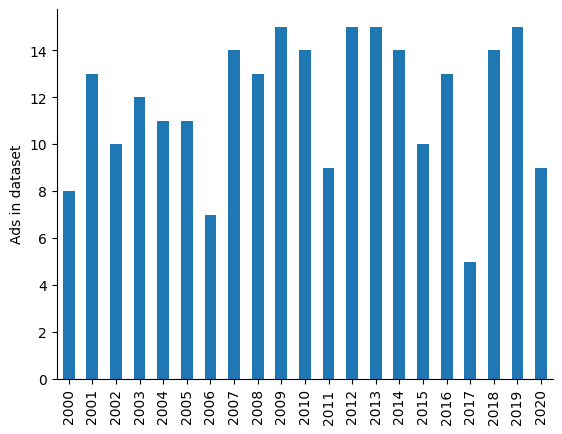

In [5]:
ax = ads.year.value_counts().sort_index().plot.bar()
ax.set(ylabel='Ads in dataset')

Most common brands-years:

In [6]:
ads.groupby('brand year'.split()).size().sort_values(ascending=False).head(20)

brand      year
Bud Light  2003    7
           2005    7
           2008    7
           2004    5
           2007    5
Budweiser  2002    4
Pepsi      2001    4
Bud Light  2002    4
Hynudai    2013    4
Budweiser  2000    4
Bud Light  2019    4
Budweiser  2013    3
           2007    3
Hynudai    2011    3
Doritos    2010    3
           2015    3
Budweiser  2015    3
Coca-Cola  2009    3
Budweiser  2004    3
Coca-Cola  2012    3
dtype: int64

In [7]:
with pd.option_context('display.max_colwidth', None):
    display(ads.groupby('brand').year.unique().map(np.sort).reset_index())

,brand,year
0,Bud Light,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2016, 2018, 2019, 2020]"
1,Budweiser,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]"
2,Coca-Cola,"[2007, 2008, 2009, 2011, 2012, 2014, 2015, 2016, 2018, 2019, 2020]"
3,Doritos,"[2001, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2018, 2019, 2020]"
4,E-Trade,"[2000, 2001, 2002, 2007, 2009, 2010, 2012, 2013, 2018]"
5,Hynudai,"[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019, 2020]"
6,Kia,"[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]"
7,NFL,"[2001, 2003, 2010, 2012, 2014, 2016, 2017, 2018, 2019, 2020]"
8,Pepsi,"[2001, 2002, 2003, 2004, 2005, 2006, 2008, 2009, 2011, 2012, 2013, 2015, 2016, 2018, 2019, 2020]"
9,Toyota,"[2004, 2007, 2012, 2014, 2015, 2016, 2018, 2019, 2020]"


Feature prevalence:

In [8]:
def clearempty(axs):
    for ax in np.ravel(np.atleast_1d(axs)):
        if not (ax.artists or ax.lines or ax.patches):
            ax.set_visible(False)

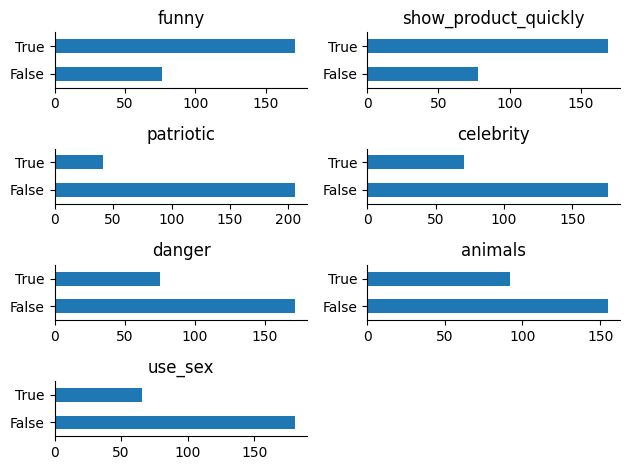

In [9]:
fig, axs = plt.subplots(4, 2)
for (ax, feature) in zip(axs.ravel(), base_features):
    ads[feature].value_counts().sort_index().plot.barh(ax=ax)
    ax.set(title=feature)
clearempty(axs)
plt.tight_layout()

Any obvious trends vs time?

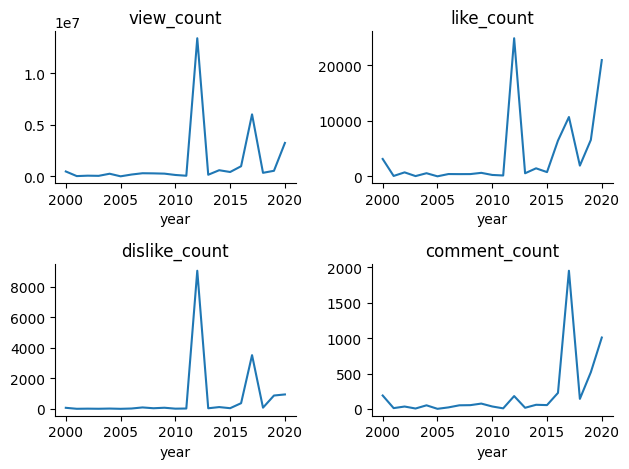

In [10]:
fig, axs = plt.subplots(2, 2)
for (ax, feature) in zip(axs.ravel(), count_features):
    ads.groupby('year')[feature].mean().plot(ax=ax)
    ax.set(title=feature)
clearempty(axs)
plt.tight_layout()

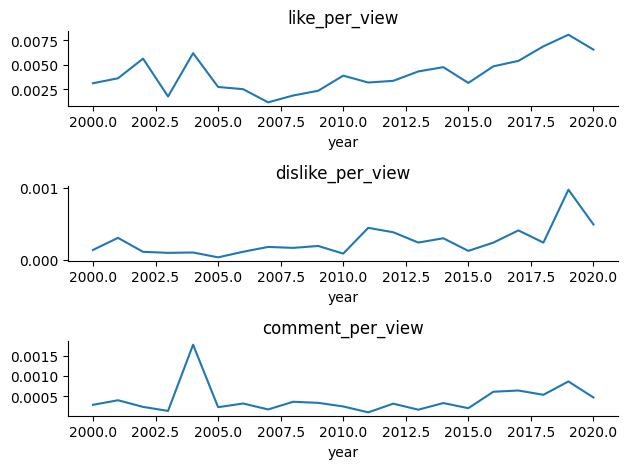

In [12]:
fig, axs = plt.subplots(3)
for (ax, feature) in zip(axs.ravel(), interaction_features):
    ads.groupby('year')[feature].mean().plot(ax=ax)
    ax.set(title=feature)
clearempty(axs)
plt.tight_layout()

## Likeability

Most disliked ads:

In [93]:
with pd.option_context('display.max_colwidth', None):
    display(ads.sort_values('dislike_frac', ascending=False).head()['year brand dislike_frac view_count youtube_url description'.split()])

,year,brand,dislike_frac,view_count,youtube_url,description
223,2019,Bud Light,0.642857,36683.0,https://www.youtube.com/watch?v=hkSQ2Vr41bM,Ad Meter 2019: Check out Bud Light's third and final ad from the 2019 Super Bowl. Medieval barbers discuss beer ingredients while giving bowl cuts. \nUSA TODAY Super Bowl Ad Meter 2019 https:/// \nWatch other Super Bowl Ads here: http://bit.ly/2UEjBqo\n#AdMeter #AdMeter2019
128,2011,Bud Light,0.500000,350.0,https://www.youtube.com/watch?v=JJn1vM7LB1Y,NaN
97,2008,Hynudai,0.379310,13312.0,https://www.youtube.com/watch?v=PsKJUnGEGSs,"This Hyundai Super Bowl Commercial introduces the new 2008 Genesis luxury sedan car. The copy reads, ""More spacious than a BMW 7-series. Priced like a 3-series. Introducing the 375 horsepower Hyundai Genesis. Summer 2008. Think about it."""
17,2001,Pepsi,0.333333,788.0,https://www.youtube.com/watch?v=1nmPv4M8Ps8,"sweaty hot subway ride and dreams of a get away with a Pepsi, mid 90's commercial"
232,2019,Kia,0.333333,518.0,https://www.youtube.com/watch?v=nONhop0Kq-E,NaN


How liked is an ad, really?  A Bayesian model with partial pooling may give a better estimate than `like_frac` or `dislike_frac`, since view counts and like/dislike response rates vary within the dataset by many orders of magnitude.

In [15]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=1)
    kappa_log = pm.Exponential('kappa_log', lam=1.5)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))
    p = pm.Beta('p', alpha=kappa * mu, beta=kappa * (1-mu), shape=len(vads))
    y = pm.Binomial('y', n=vads.like_dislike_count, p=p, observed=vads.like_count)
    
with model:
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, kappa_log, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

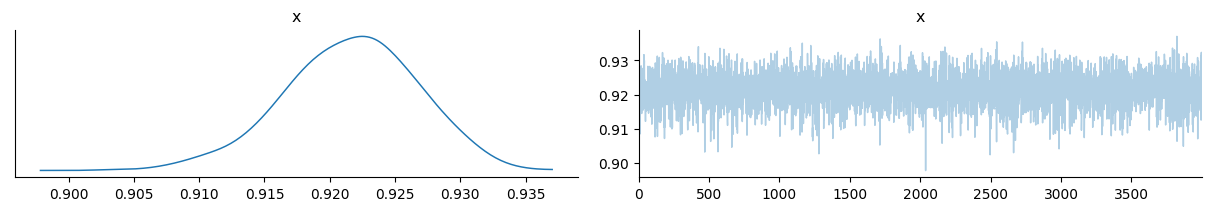

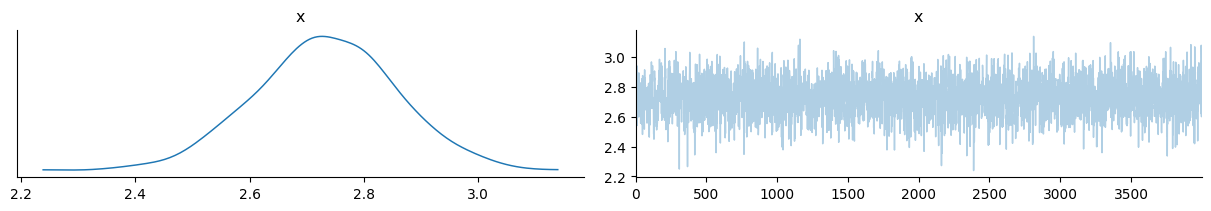

In [16]:
az.plot_trace(trace['mu'])
az.plot_trace(trace['kappa_log'])

In [17]:
trace['p'].shape

(4000, 231)

In [18]:
vads['p_like'] = trace['p'].mean(axis=0)

In [19]:
order = np.argsort(vads.p_like)[::-1]

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

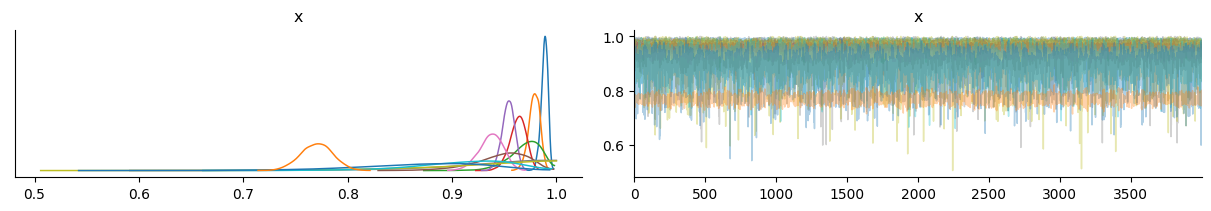

In [20]:
az.plot_trace(trace['p'].T[order[::20]])

In [110]:
with pd.option_context('display.max_colwidth', None):
    cols = 'year brand like_count dislike_count like_frac p_like youtube_url description'.split()
    print('Most likeable:')
    display(vads.iloc[order.values].head()[cols].round(4).fillna(0, downcast='infer'))
    print('\n\nLeast likeable:')
    display(vads.iloc[order.values].tail()[cols].round(4).fillna(0, downcast='infer'))

Most likeable:


,year,brand,like_count,dislike_count,like_frac,p_like,youtube_url,description
154,2013,Hynudai,1042,11,0.9896,0.9885,https://www.youtube.com/watch?v=jvm68nEAU7o,0
143,2012,Toyota,1153,13,0.9889,0.9880,https://www.youtube.com/watch?v=oYdJKey7VpU,"http://www.MotorcarLife.com : This commercial shown in a 2012 Super Bowl / Big Game Commercial discusses how Toyota reinvented the 2012 Camry, and also explored other areas for reinvention including a Couch (Female & Male), DMV, Baby, Blender, Plants, Police Officer, Curtains, and Rain."
26,2002,Pepsi,5929,73,0.9878,0.9877,https://www.youtube.com/watch?v=TG4giyL-4Sk,"Britney Spears 2001 ""Now and Then"" Pepsi commercial.\n\n Check out http://www.britney-online.net for more.\n\nDISCLAIMER: I do not own the video(s) nor the song(s) used here, this is for promotional and entertainment purposes only. No copyright infringement intended."
177,2015,Kia,74,0,1.0000,0.9864,https://www.youtube.com/watch?v=nayeYTmEdYw,0
140,2012,Kia,396,5,0.9875,0.9852,https://www.youtube.com/watch?v=9RI6OGXq11Y,"he new 2012 Kia Optima is tearing up the track with Adriana Lima, Chuck Liddell and Motley Crue."




Least likeable:


,year,brand,like_count,dislike_count,like_frac,p_like,youtube_url,description
75,2007,Doritos,2508,861,0.7444,0.7453,https://www.youtube.com/watch?v=kNxgxF-7SfA,Live the Flavor
191,2017,Budweiser,48423,17113,0.7389,0.7389,https://www.youtube.com/watch?v=HtBZvl7dIu4,This is the story of our founder’s ambitious journey to America in pursuit of his dream: to brew the King of Beers.\n\nSubscribe to Budweiser: youtube.com/budweiser\n\nConnect with Budweiser: \n\nFacebook: facebook.com/BudweiserUSA\nInstagram: instagram.com/budweiser\nTwitter: twitter.com/budweiser
90,2008,Hynudai,18,11,0.6207,0.7239,https://www.youtube.com/watch?v=PsKJUnGEGSs,"This Hyundai Super Bowl Commercial introduces the new 2008 Genesis luxury sedan car. The copy reads, ""More spacious than a BMW 7-series. Priced like a 3-series. Introducing the 375 horsepower Hyundai Genesis. Summer 2008. Think about it."""
135,2012,Coca-Cola,92333,42386,0.6854,0.6854,https://www.youtube.com/watch?v=S2nBBMbjS8w,"This game day spot will change depending on the circumstances. If the 2nd quarter is particularly stressful, then NE_Bear will relieve some tension when his friends toss him a Coke...if he can catch it. http://www.CokePolarBowl.com #GameDayPolarBears"
209,2019,Bud Light,65,117,0.3571,0.4010,https://www.youtube.com/watch?v=hkSQ2Vr41bM,Ad Meter 2019: Check out Bud Light's third and final ad from the 2019 Super Bowl. Medieval barbers discuss beer ingredients while giving bowl cuts. \nUSA TODAY Super Bowl Ad Meter 2019 https:/// \nWatch other Super Bowl Ads here: http://bit.ly/2UEjBqo\n#AdMeter #AdMeter2019


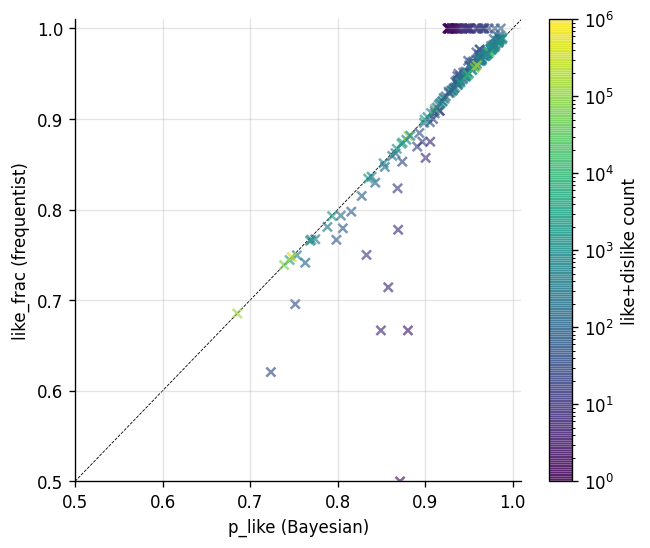

In [143]:
fig, ax = plt.subplots(figsize=(6,5), dpi=120)
sc = ax.scatter('p_like', 'like_frac', c='like_dislike_count',
                marker='x', s=30, alpha=.66,
                data=vads, cmap='viridis', norm=plt.matplotlib.colors.LogNorm(1, 1e6))
fig.colorbar(sc, label='like+dislike count')
lim = .5, 1.01
ax.plot(lim, lim, 'k--', zorder=-10, lw=.5)
ax.set(xlim=lim, ylim=lim, xlabel='p_like (Bayesian)', ylabel='like_frac (frequentist)')
ax.grid()

## Predictive features

In [144]:
def lm_and_anova(target):
    """
    Perform linear model fit and ANOVA; plot model coefficients and variance explained.
    """
    m = smf.ols(
        f"""{target} ~ celebrity + animals + funny + danger
                       + use_sex + patriotic + show_product_quickly""",
        vads
    ).fit()
    anova = (
        sm.stats.anova_lm(m, typ=2)
        .assign(pct_variation = lambda x: 100 * x.sum_sq / x.sum_sq.sum())
        .sort_values('pct_variation', ascending=False)
    )

    fig, ax = plt.subplots(figsize=(5,2))
    p = m.params.drop('Intercept').sort_values(ascending=False)
    p.index = p.index.str.replace(r'\[.*', '')
    p.plot.barh(color=np.where(p.gt(0), 'C0', 'C3'))
    lim = 1.05 * p.abs().max()
    lim = (-lim, lim)
    ax.set(xlim=lim, xlabel='Coefficient')
    ax.spines['left'].set_visible(False)
    ax.grid()

    fig, ax = plt.subplots(figsize=(5,2))
    anova.iloc[1:].iloc[::-1].pct_variation.plot.barh()
    ax.set(xlabel='% variation explained')
    ax.grid()

### Likeability

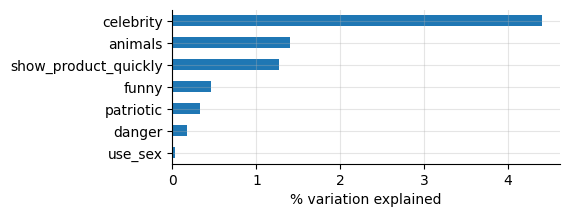

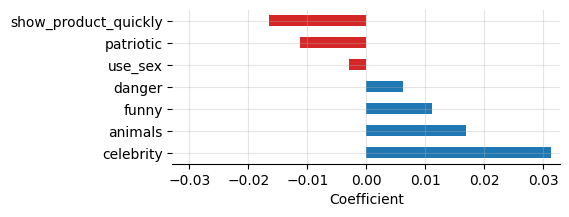

In [80]:
lm_and_anova('p_like')

### View count

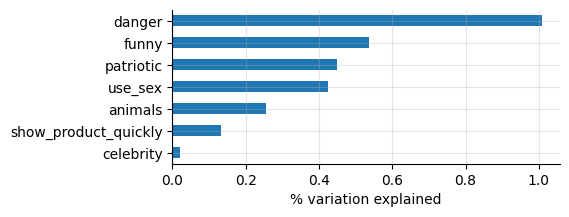

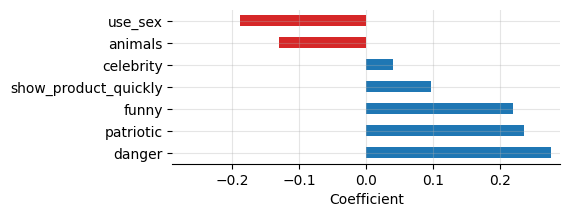

In [81]:
lm_and_anova('np.log10(view_count)')

## Analysis by brand

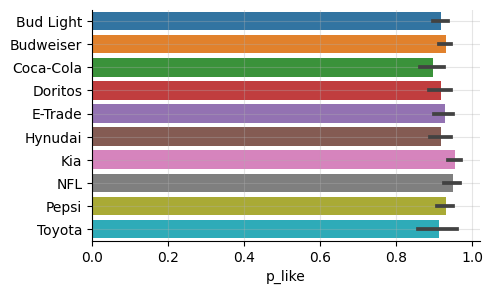

In [162]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot('p_like', 'brand', data=vads.sort_values('brand'))
ax.set(ylabel='')
ax.grid()

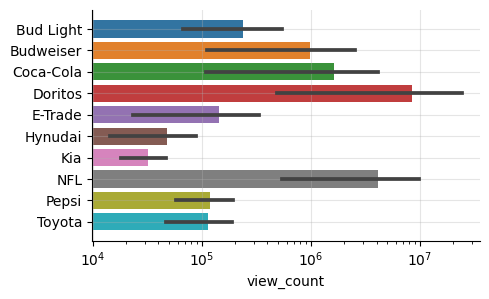

In [163]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot('view_count', 'brand', data=vads.sort_values('brand'))
ax.semilogx()
ax.set(ylabel='')
ax.grid()

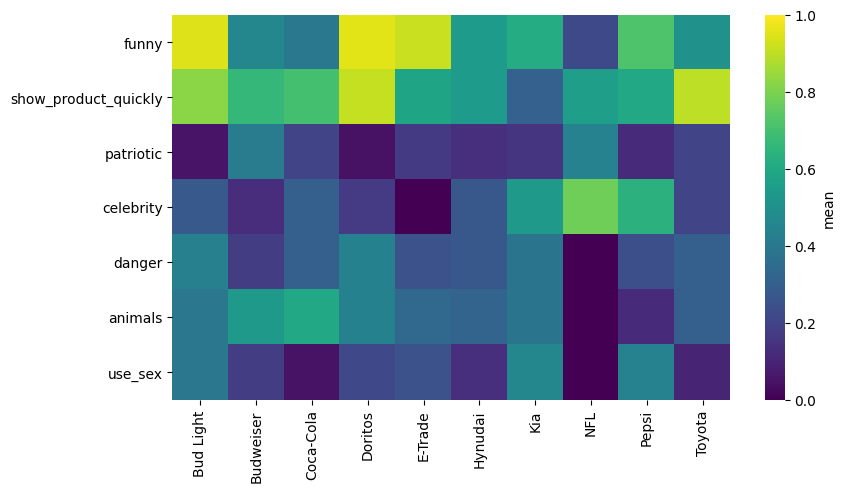

In [190]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(
    vads.groupby('brand')[base_features].mean().T,
    vmin=0, vmax=1, cmap='viridis',
    cbar_kws=dict(label='mean'), ax=ax)
ax.set(xlabel='');

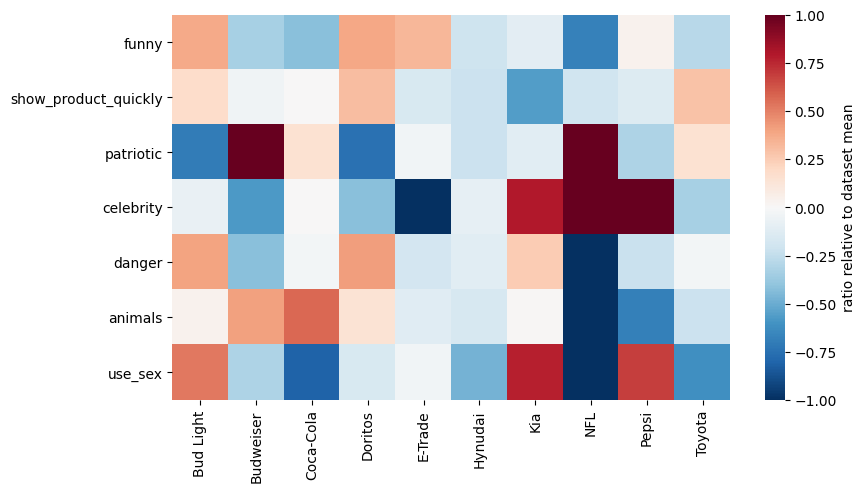

In [191]:
d = vads.groupby('brand')[base_features].mean() / vads[base_features].mean() - 1
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(
    d.T,
    vmin=-1, vmax=1, cmap='RdBu_r',
    cbar_kws=dict(label='ratio relative to dataset mean'), ax=ax)
ax.set(xlabel='');